# Setup

In [4]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.2)

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.models import load_model
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
VOCAB_SIZE = 50000  # vocabulary size
MAX_LEN = 200

# Load data
We use the <a href="https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification">Cyberbullying Classification</a> dataset from Kaggle

## Content:

* **tweet_text** - Text of the tweet
* **cyberbullying_type** - Type of cyberbullying harassment.


In [6]:
cleaned_tweets_df = pd.read_csv("./cleaned_tweets.csv")
cleaned_tweets_df

,clean_text,cyberbullying_type
0,word #katandandre food crapilicious #mkr,not_cyberbullying
1,#aussietv white #mkr #theblock #imacelebrityau #today #sunrise #studio #neighbours #wonderlandten #etc,not_cyberbullying
2,classy whore red velvet cupcake,not_cyberbullying
3,meh p thanks head concerned another angry dude twitter,not_cyberbullying
4,isi account pretending kurdish account like islam lie,not_cyberbullying
...,...,...
47687,black ppl expected anything depended anything yet free participate work enjoy freedom human across globe waste energy past wasting building future,ethnicity
47688,turner withhold disappointment turner called court abominable conclave negro hating demon one exception issued another decree colored men woman must driven jim crow car whenever suit whim white community,ethnicity
47689,swear god dumb nigger bitch got bleach hair reeeeeal fuckin soon fuck,ethnicity
47690,yea fuck rt youre nigger fucking unfollow fucking dumb nigger,ethnicity


In [7]:
cleaned_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   clean_text          47304 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [8]:
cleaned_tweets_df.isnull().sum()

clean_text            388
cyberbullying_type      0
dtype: int64

In [9]:
# Drop null values
cleaned_tweets_df.dropna(inplace=True)
cleaned_tweets_df.reset_index(drop=True, inplace=True)

# Data preprocessing

In [10]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower',
    output_mode='int',
    output_sequence_length=MAX_LEN)

vectorize_layer.adapt(cleaned_tweets_df["clean_text"])

In [11]:
vectorized_text = vectorize_layer(cleaned_tweets_df["clean_text"])

print(vectorized_text)

tf.Tensor(
[[   86  2219   585 ...     0     0     0]
 [38675    27    24 ...     0     0     0]
 [ 2114  1123   725 ...     0     0     0]
 ...
 [  722   107    10 ...     0     0     0]
 [  877     3    17 ...     0     0     0]
 [  432     7   599 ...     0     0     0]], shape=(47304, 200), dtype=int64)


In [12]:
# Encode 'cyberbullying_type' column
cyberbullying_type_dict = {'not_cyberbullying': 0, 'gender': 1, 'religion': 2, 'other_cyberbullying': 3, 'age': 4, 'ethnicity': 5}
cleaned_tweets_df["cyberbullying_type"] = cleaned_tweets_df["cyberbullying_type"].map(cyberbullying_type_dict)

## train-test split

In [13]:
X = vectorized_text.numpy()
y = cleaned_tweets_df["cyberbullying_type"].values

print(X.shape, y.shape)

(47304, 200) (47304,)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(37843, 200) (9461, 200)


In [15]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
y_train_ohe = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_ohe = ohe.transform(y_test.reshape(-1, 1)).toarray()

print(y_train_ohe.shape, y_test_ohe.shape)

(37843, 6) (9461, 6)


# Create model

In [16]:
# Build lstm model
def build_model(n_units=32, drop_rate=0):
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(VOCAB_SIZE, 32)(inputs)
    x = layers.SpatialDropout1D(0.2)(x)

    # Add 2 bidirectional LSTMs
    x = layers.Bidirectional(layers.LSTM(n_units, dropout=drop_rate, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(n_units, dropout=drop_rate))(x)

    x = layers.Dense(48, activation="relu")(x)
    outputs = layers.Dense(6, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    
    return model



In [17]:
model = build_model(n_units=48, drop_rate=0.2)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 32)          1600000   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 32)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, None, 96)         31104     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 96)               55680     
 nal)                                                            
                                                             

In [18]:
model.compile(optimizer=tf.optimizers.RMSprop(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train Model

In [19]:
batch_size = 64
epochs = 8

In [20]:
# Save model checkpoints
checkpoint_filepath = "./training_checkpoints/checkpoint"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [21]:
hist = model.fit(X_train, y_train_ohe, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_test, y_test_ohe),
                 callbacks=[checkpoint_cb])

Epoch 1/8
592/592 [==============================] - 35s 35ms/step - loss: 0.7824 - accuracy: 0.6570 - val_loss: 0.4867 - val_accuracy: 0.7819
Epoch 2/8
592/592 [==============================] - 20s 33ms/step - loss: 0.4375 - accuracy: 0.8186 - val_loss: 0.4415 - val_accuracy: 0.8164
Epoch 3/8
592/592 [==============================] - 27s 46ms/step - loss: 0.3864 - accuracy: 0.8458 - val_loss: 0.4041 - val_accuracy: 0.8248
Epoch 4/8
592/592 [==============================] - 22s 38ms/step - loss: 0.3563 - accuracy: 0.8612 - val_loss: 0.4127 - val_accuracy: 0.8327
Epoch 5/8
592/592 [==============================] - 20s 33ms/step - loss: 0.3329 - accuracy: 0.8689 - val_loss: 0.4098 - val_accuracy: 0.8314
Epoch 6/8
592/592 [==============================] - 20s 35ms/step - loss: 0.3187 - accuracy: 0.8761 - val_loss: 0.4073 - val_accuracy: 0.8384
Epoch 7/8
592/592 [==============================] - 20s 34ms/step - loss: 0.3077 - accuracy: 0.8827 - val_loss: 0.4044 - val_accuracy: 0.8364

# Evaluate model

In [24]:
loss_df = pd.DataFrame(hist.history)
loss_df

,loss,accuracy,val_loss,val_accuracy
0,0.782431,0.657004,0.486705,0.781947
1,0.437507,0.818566,0.441468,0.816404
2,0.386447,0.845784,0.404146,0.824754
3,0.356320,0.861163,0.412681,0.832682
4,0.332863,0.868853,0.409818,0.831413
5,0.318743,0.876093,0.407318,0.838389
6,0.307718,0.882700,0.404413,0.836381
7,0.297234,0.886716,0.417002,0.833421


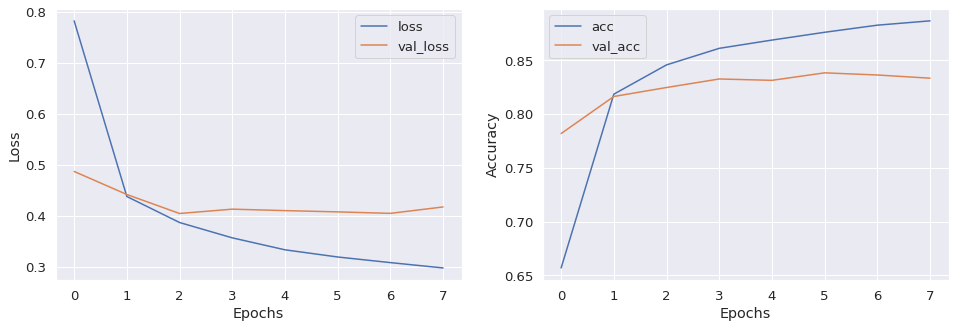

In [26]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_df["loss"], label="loss")
plt.plot(loss_df["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_df["accuracy"], label="acc")
plt.plot(loss_df["val_accuracy"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [27]:
# Restore weights
model.load_weights(checkpoint_filepath)
scores = model.evaluate(X_test, y_test_ohe)

print(scores)

296/296 [==============================] - 7s 23ms/step - loss: 0.4073 - accuracy: 0.8384
[0.4073180854320526, 0.8383891582489014]


In [28]:
# Save model
model.save("saved_models/cyberbullying_lstm.h5")

# Predictions

In [29]:
# Load model
loaded_model = load_model("saved_models/cyberbullying_lstm.h5")

In [30]:
y_pred = loaded_model.predict(X_test)
predictions = np.argmax(y_pred, axis=1)
predictions

296/296 [==============================] - 7s 18ms/step


array([1, 1, 3, ..., 3, 0, 2])

In [31]:
cm = confusion_matrix(y_test, predictions)

print(cm)

[[ 734   86   81  674   18    6]
 [  80 1331    5  126    1    5]
 [  17    5 1554   17    1    5]
 [ 211   83    3 1212   14    7]
 [  22    2    3   13 1503    4]
 [   6    4    7   21    2 1598]]


In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.46      0.55      1599
           1       0.88      0.86      0.87      1548
           2       0.94      0.97      0.96      1599
           3       0.59      0.79      0.67      1530
           4       0.98      0.97      0.97      1547
           5       0.98      0.98      0.98      1638

    accuracy                           0.84      9461
   macro avg       0.84      0.84      0.83      9461
weighted avg       0.84      0.84      0.83      9461

